In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch.utils.data import Dataset, DataLoader

from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

In [2]:
from scripts.AutoEncoder import AutoEncoder, AutoEncoderDataset, Encoder, Decoder
from scripts.utils import train_keys, target_keys, ScaleData

In [3]:
train = "/share/rcifdata/jbarr/UKAEAGroupProject/data/train_data_clipped.pkl"
df_train = pd.read_pickle(train)
df_train = df_train[train_keys]
df_train, scaler = ScaleData(df_train)

df_train.describe()

,ane,ate,autor,machtor,x,zeff,gammae,q,smag,alpha,ani1,ati0,normni1,ti_te0,lognustar
count,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07,1.767264e+07
mean,-4.244571e-17,-2.204141e-15,-1.845331e-14,9.872596e-16,1.443307e-15,5.825100e-16,-2.163914e-14,1.116600e-15,-1.048156e-16,8.099105e-16,-8.453134e-16,9.617863e-16,1.647093e-15,1.539637e-14,1.514649e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.384711e+01,-6.585977e+00,-1.884677e+01,-2.065468e+00,-1.685289e+00,-1.270876e+00,-2.605210e+01,-1.226404e+00,-2.207143e+00,-4.272697e+00,-1.542753e+01,-7.614730e+00,-1.810760e+00,-3.966175e+00,-3.129009e+00
25%,-4.040953e-01,-5.670599e-01,-2.922102e-01,-5.312093e-01,-9.628142e-01,-7.966956e-01,4.273997e-02,-7.364278e-01,-6.534275e-01,-4.755039e-01,-3.499717e-01,-5.471105e-01,-2.686078e-01,-1.080478e-01,-7.260516e-01
50%,-2.005211e-01,-2.616720e-01,-2.922102e-01,-5.312093e-01,-1.396549e-01,-1.542101e-01,4.273997e-02,-2.877295e-01,-3.921313e-01,-3.348355e-01,-1.956296e-01,-2.503222e-01,-2.116415e-01,-1.080478e-01,-1.348429e-01
75%,9.590093e-02,2.096182e-01,-2.717016e-02,1.510355e-01,9.351353e-01,5.066278e-01,4.273997e-02,4.397159e-01,2.817471e-01,8.098745e-02,4.703473e-02,2.638433e-01,-9.624531e-02,-1.080478e-01,5.857065e-01
max,1.378378e+01,1.087966e+01,2.907871e+01,5.549705e+00,1.679477e+00,1.529337e+01,1.310198e+01,2.523304e+01,6.818529e+00,1.860037e+01,1.447752e+01,1.282571e+01,2.074059e+01,2.026225e+01,6.969653e+00


In [42]:
test = "/share/rcifdata/jbarr/UKAEAGroupProject/data/test_data_clipped.pkl"


df_test = pd.read_pickle(test)
target = df_test['target']
df_test_good = df_test[df_test.target == 1]
df_test_good = df_test[train_keys]

df_test_good,_ = ScaleData(df_test_good, scaler)

n = 10_000
df_test_good.describe()

,ane,ate,autor,machtor,x,zeff,gammae,q,smag,alpha,ani1,ati0,normni1,ti_te0,lognustar
count,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06,3.339495e+06
mean,1.926529e-02,1.662980e-01,4.578848e-02,2.190920e-02,1.646646e-01,4.263971e-02,6.688703e+03,1.012945e-01,7.033223e-02,1.289329e-01,1.027128e-01,2.115670e-01,1.948940e-02,-9.987404e-03,-5.999096e-02
std,1.074614e+01,2.795503e+00,1.528600e+00,9.740142e-01,9.627886e-01,1.012517e+00,2.937118e+07,1.039847e+00,1.333174e+00,1.806903e+00,2.975709e+00,6.430983e+00,1.012750e+00,1.132715e+00,1.003193e+00
min,-2.998208e+03,-9.978861e+02,-1.147906e+02,-2.065468e+00,-1.685289e+00,-1.270876e+00,-5.663635e+09,-1.226404e+00,-1.110284e+02,-4.862196e+01,-1.623182e+02,-1.299600e+03,-1.810760e+00,-3.966175e+00,-3.129009e+00
25%,-4.166336e-01,-4.847199e-01,-2.922102e-01,-5.312093e-01,-5.938391e-01,-7.512224e-01,4.273997e-02,-6.458124e-01,-6.124451e-01,-4.430092e-01,-3.465434e-01,-4.406556e-01,-2.633703e-01,-1.435567e-01,-7.878428e-01
50%,-2.107964e-01,-1.340906e-01,-2.922102e-01,-5.312093e-01,2.060826e-01,-1.107449e-01,4.273997e-02,-1.720750e-01,-2.914123e-01,-2.641003e-01,-1.795813e-01,-4.795958e-02,-2.105530e-01,-1.080478e-01,-2.209285e-01
75%,9.020700e-02,3.506906e-01,2.035491e-01,3.342463e-01,9.663403e-01,5.571787e-01,4.273997e-02,5.493737e-01,3.634449e-01,2.456772e-01,6.602409e-02,4.506347e-01,-4.800974e-02,-1.080478e-01,5.334983e-01
max,2.998760e+03,9.383249e+02,8.068238e+01,5.549705e+00,1.679477e+00,1.529337e+01,5.663635e+09,2.523304e+01,3.739348e+02,2.622727e+02,1.804430e+02,1.297990e+03,2.074059e+01,2.026225e+01,8.073341e+00


## Model 1 - AE trained on inputs that give outputs

In [44]:
path = "/share/rcifdata/jbarr/UKAEAGroupProject/logs/AutoEncoder/Run-9/experiment_name=0-epoch=127-val_loss=0.20.ckpt"

model = AutoEncoder.load_from_checkpoint(path, n_input = 15, batch_size = 2048, epochs = 150, learning_rate = 0.0025)
encoder = model.encoder

### Evaluate on inputs that give outputs

In [45]:
data_good = torch.from_numpy(df_test_good.values).float()
outputs_good = encoder.forward(data_good).detach().numpy()

<IPython.core.display.Javascript object>


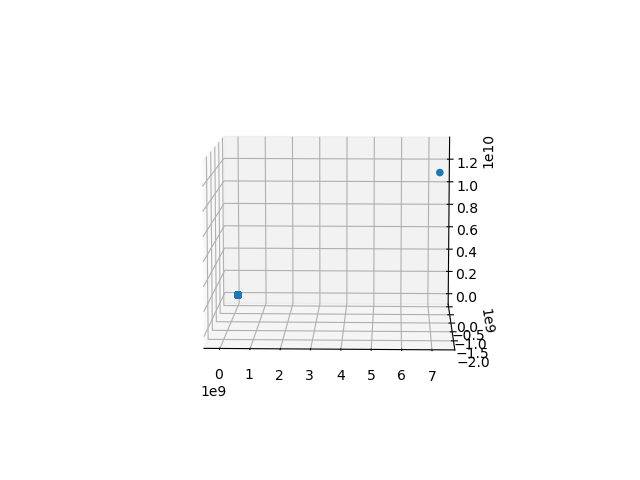

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(outputs_good[:n,0], outputs_good[:n,1],outputs_good[:n,2])
fig.show()

<IPython.core.display.Javascript object>


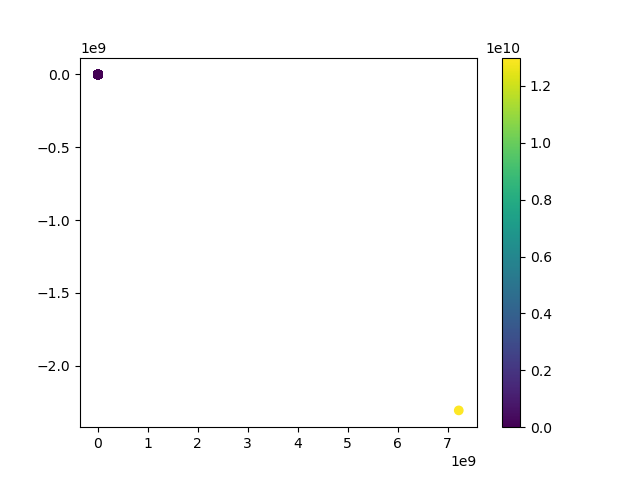

In [47]:
plt.figure()

sc = plt.scatter(outputs_good[:n,0], outputs_good[:n,1], c = outputs_good[:n,2])
plt.colorbar(sc)
plt.show()

### Plot  input and output distributions

In [49]:
AE_output = model.forward(data_good).detach().numpy()
df_ae_output = pd.DataFrame(AE_output, columns = train_keys)
df_ae_output['AE'] = 'Outputs'

df_test_tmp = df_test_good
df_test_tmp['AE'] = 'Inputs'

In [50]:
df_compare = pd.concat([df_ae_output, df_test_tmp], ignore_index=True)
df_compare_sample = df_compare.sample(n)

<IPython.core.display.Javascript object>


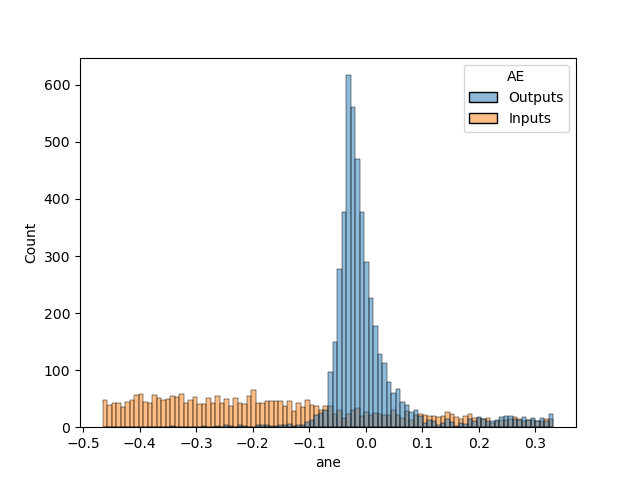

<IPython.core.display.Javascript object>


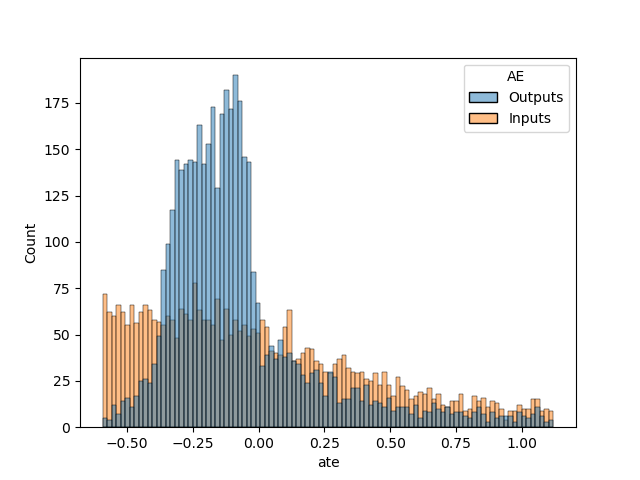

<IPython.core.display.Javascript object>


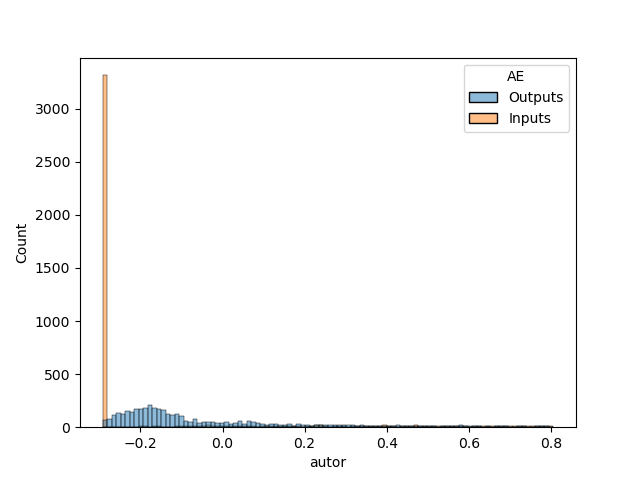

<IPython.core.display.Javascript object>


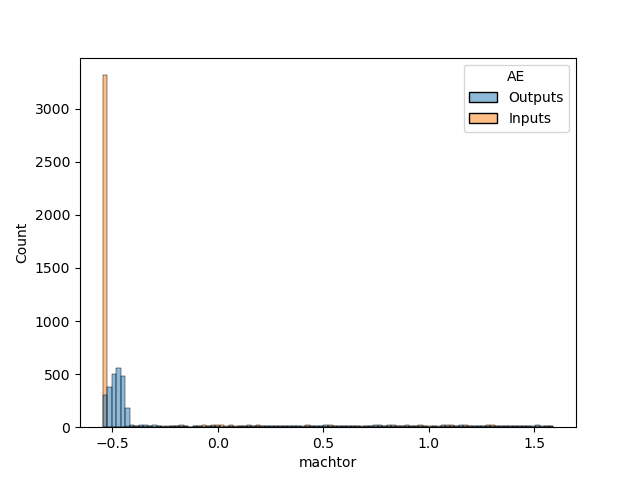

<IPython.core.display.Javascript object>


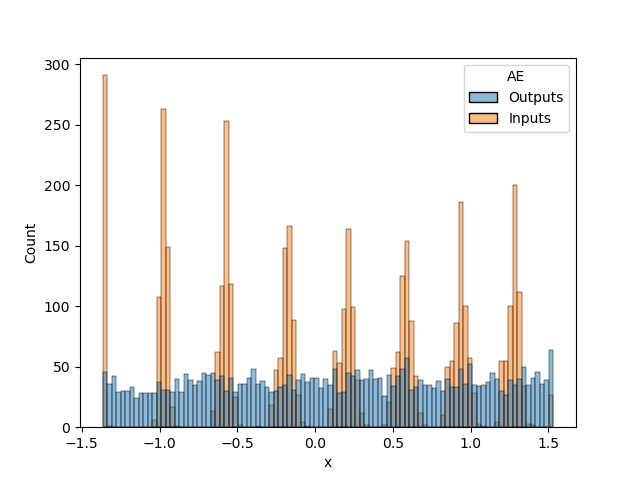

<IPython.core.display.Javascript object>


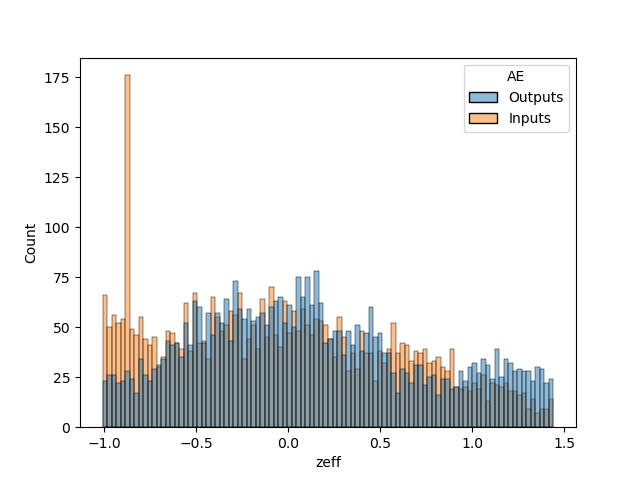

<IPython.core.display.Javascript object>


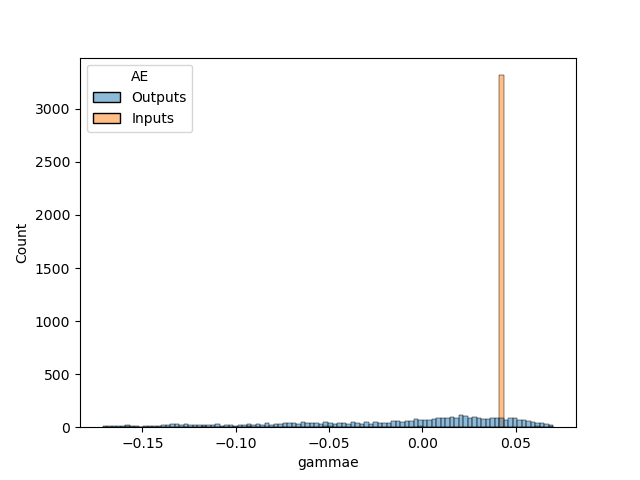

<IPython.core.display.Javascript object>


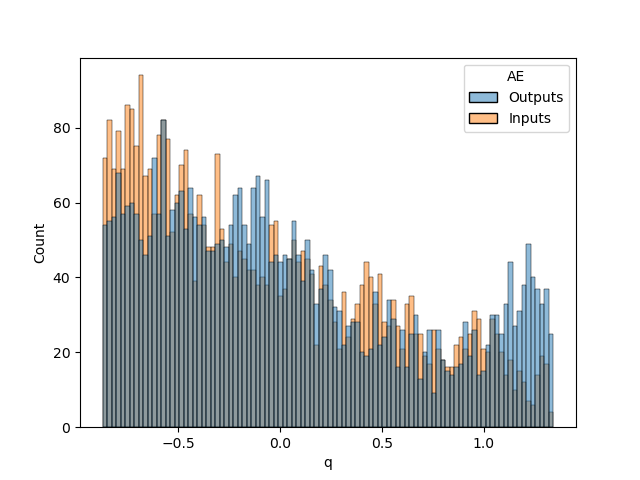

<IPython.core.display.Javascript object>


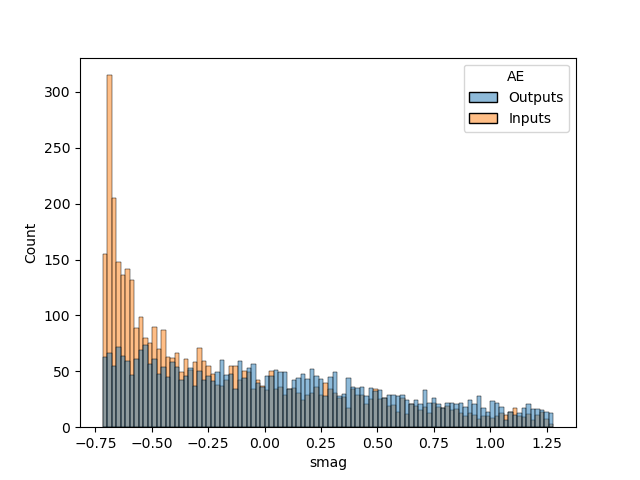

<IPython.core.display.Javascript object>


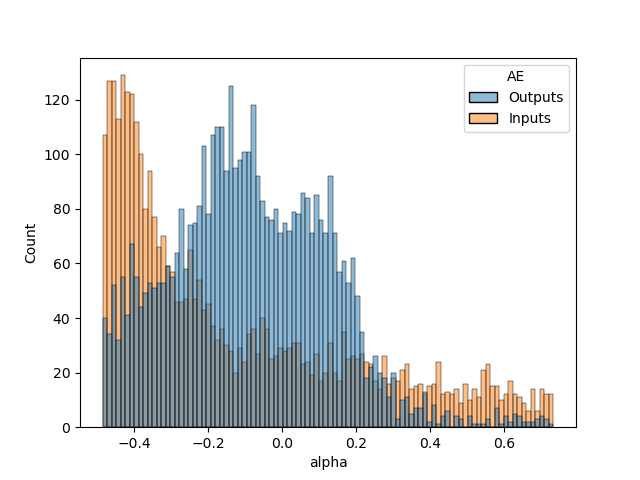

<IPython.core.display.Javascript object>


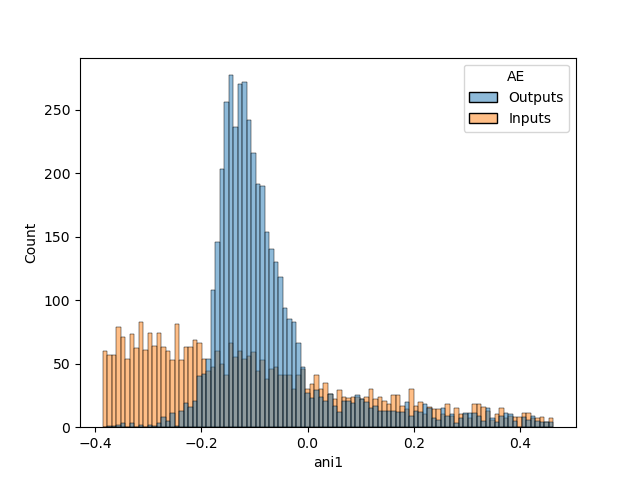

<IPython.core.display.Javascript object>


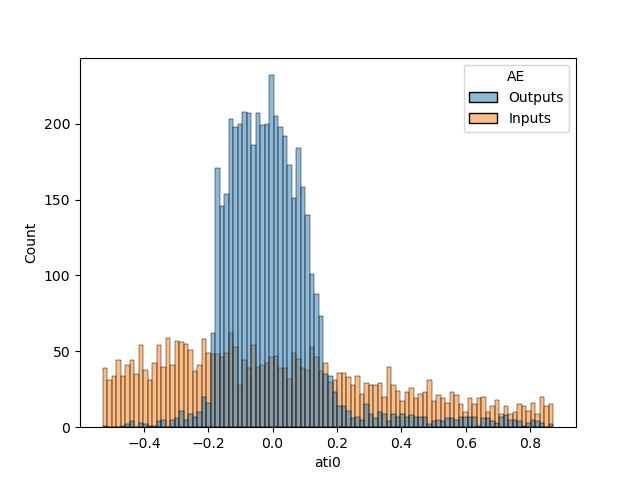

<IPython.core.display.Javascript object>


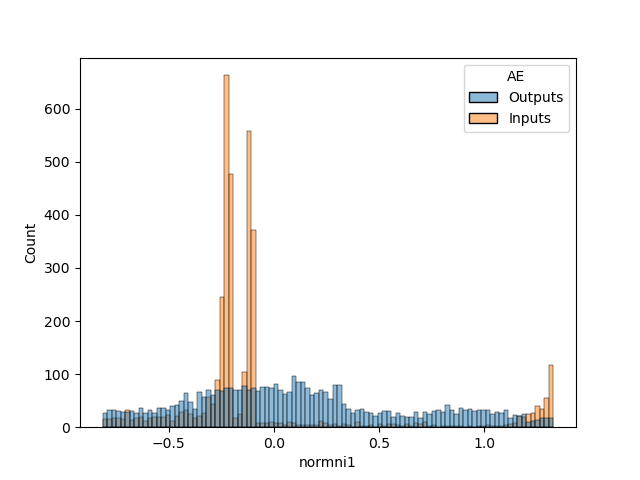

<IPython.core.display.Javascript object>


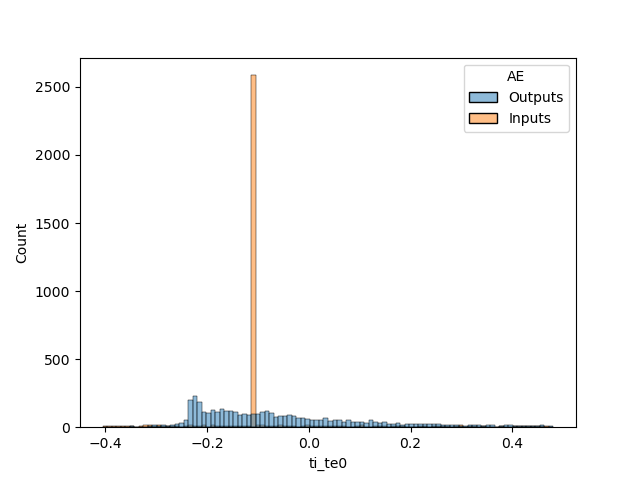

<IPython.core.display.Javascript object>


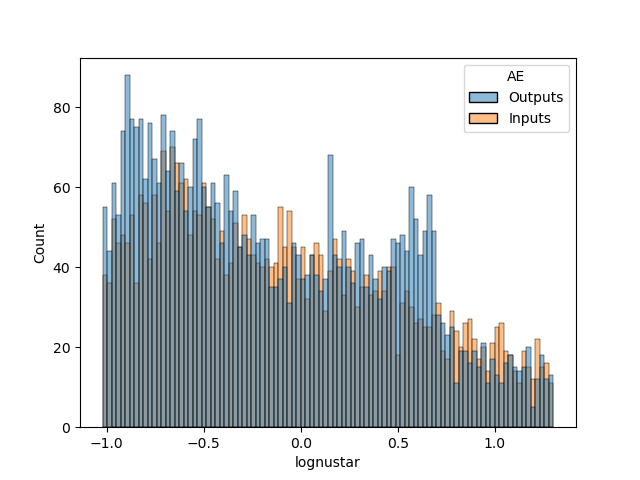

In [53]:
for i in train_keys:
    plt.figure()
    x_min = df_compare_sample[i].quantile(0.1)
    x_max = df_compare_sample[i].quantile(0.9)
    sns.histplot(data = df_compare_sample, x = i, hue = "AE", binrange = (x_min, x_max), bins = 100);
    plt.xlabel(i)

### Evaluate on all inputs

In [13]:
data_test_full = torch.from_numpy(df_full_test.values).float()
outputs_test_full = encoder.forward(data_test_full).detach().numpy()

<IPython.core.display.Javascript object>


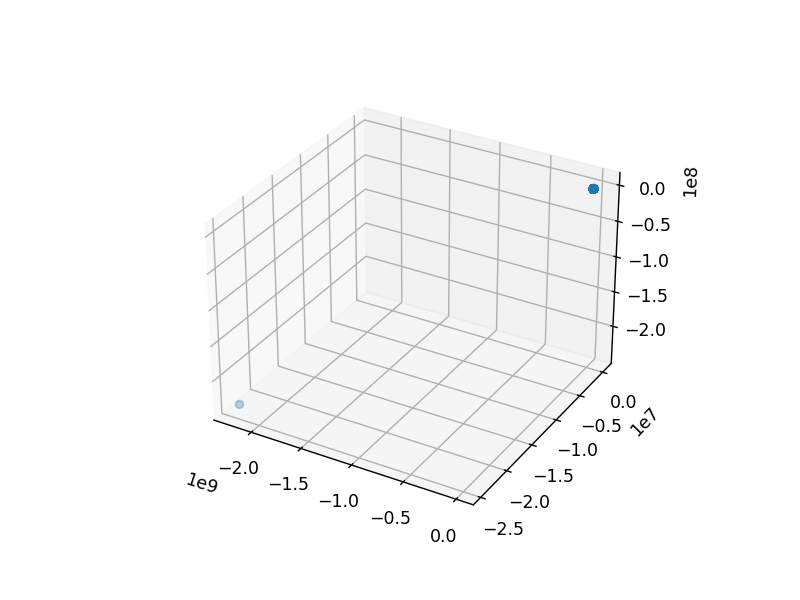

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(outputs_test_full[:n,0], outputs_test_full[:n,1],outputs_test_full[:n,2])
fig.show()

<IPython.core.display.Javascript object>


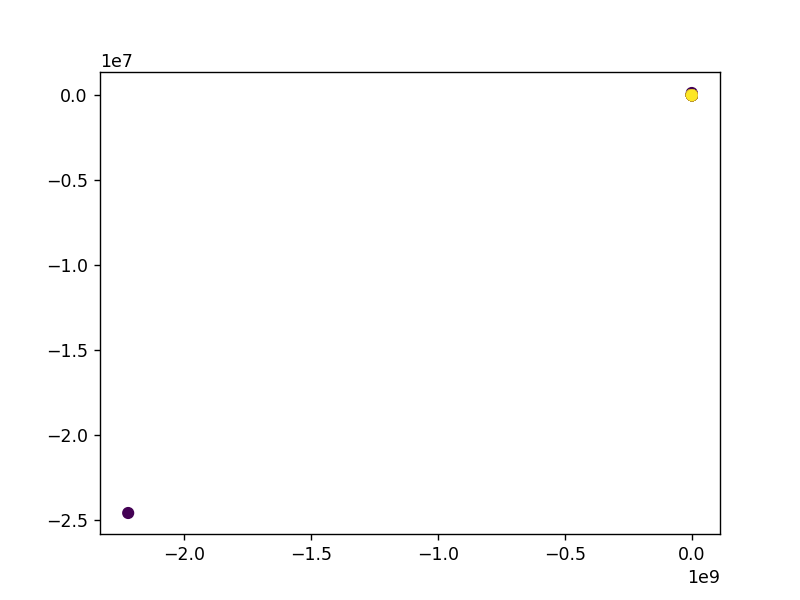

In [25]:
plt.figure()
#sc = plt.scatter(outputs_test_full[:n,0], outputs_test_full[:n,1], c = outputs_test_full[:n,2])
#plt.colorbar(sc)
plt.scatter(outputs_test_full[:n,0], outputs_test_full[:n,1], c =target[:n])

plt.show()

<IPython.core.display.Javascript object>


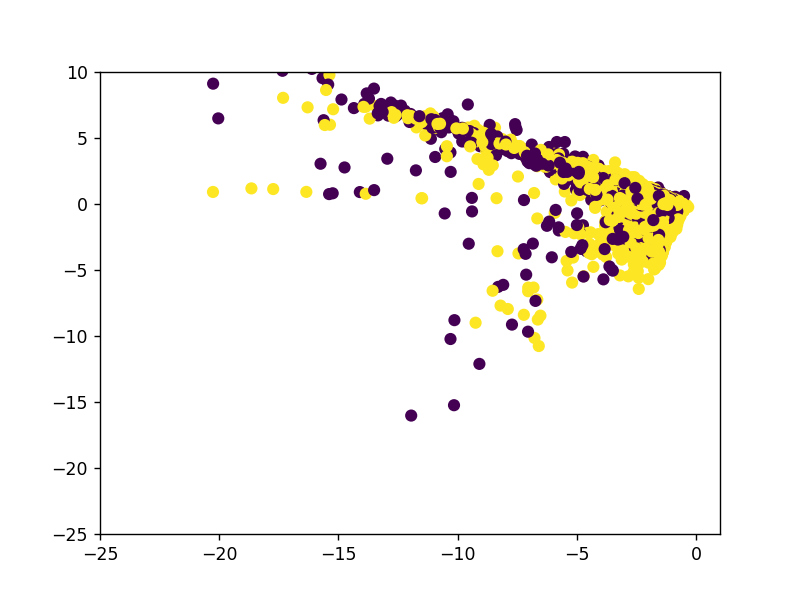

In [18]:
plt.figure()
#sc = plt.scatter(outputs_test_full[:n,0], outputs_test_full[:n,1], c = outputs_test_full[:n,2])
#plt.colorbar(sc)
plt.scatter(outputs_test_full[:n,0], outputs_test_full[:n,1], c =target[:n])
plt.xlim(-25,1)
plt.ylim(-25,10)
plt.show()

In [23]:
outputs_test_full[:n,1].min()

-24566556.0

<IPython.core.display.Javascript object>


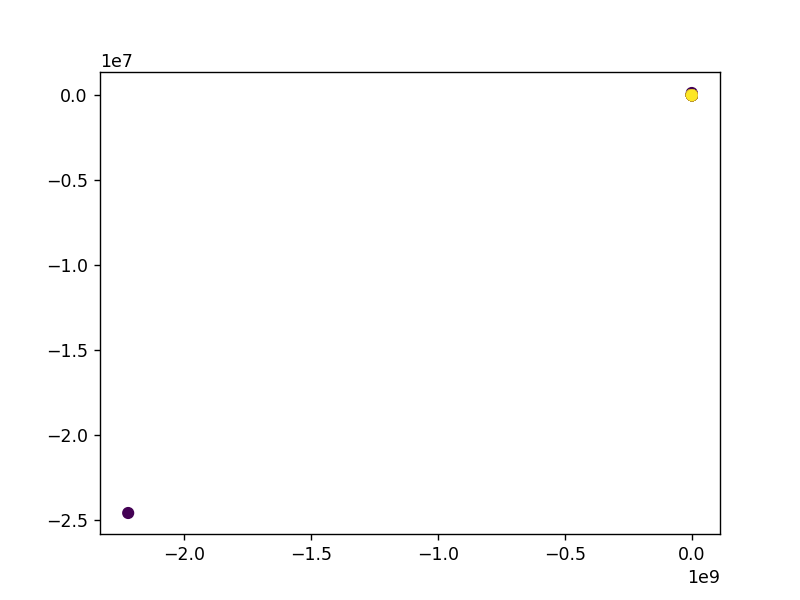

In [27]:
plt.figure()
#sc = plt.scatter(outputs_test_full[:n,0], outputs_test_full[:n,1], c = outputs_test_full[:n,2])
#plt.colorbar(sc)
plt.scatter(outputs_test_full[:n,0], outputs_test_full[:n,1], c =target[:n])
plt.show()

In [42]:
target.shape

(3339495,)

In [43]:
outputs_test_full.shape

(3339495, 3)

In [40]:
idx_left = np.where(outputs_test_full[:,0] < -1.5e9)
idx_right = np.where(outputs_test_full[:,0] > -1.5e9)

data_left = outputs_test_full[idx_left[0]]
targets_left = target[idx_left[0]]
data_right = outputs_test_full[idx_right[0]]
targets_right = target[idx_right[0]]

KeyError: '[4869, 22044, 44585, 226239, 345802, 373775, 405272, 428239, 429597, 434337, 523114, 544315, 596171, 600930, 713854, 782902, 949919, 1056473, 1251270, 1300350, 1388498, 1437497, 1673729, 1730665, 1758429, 1804495, 1825842, 1913540, 2039310, 2150569, 2151426, 2426257, 2478516, 2555026, 2637977, 2654335, 2720329, 2801054, 2803980, 2885797, 2895495, 2930903, 2981620, 3012138, 3015915, 3018684, 3065757, 3113319, 3215403, 3241123] not in index'

In [39]:
idx_left[0]

array([   4869,   22044,   44585,  129819,  135325,  226239,  345802,
        373775,  405272,  428239,  429597,  434337,  523114,  544315,
        596171,  600930,  713854,  782902,  867447,  949919, 1056473,
       1251270, 1300350, 1388498, 1437497, 1673729, 1730665, 1758429,
       1804495, 1825842, 1913540, 1923978, 2039310, 2150569, 2151426,
       2249049, 2426257, 2478516, 2555026, 2637977, 2650468, 2654335,
       2720329, 2801054, 2803980, 2820356, 2885797, 2895495, 2930903,
       2981620, 3012138, 3015915, 3018684, 3065757, 3113319, 3214974,
       3215403, 3241123, 3268321])

In [36]:
outputs_test_full[[0,1,2]]

array([[-1.3052657 ,  0.02925883,  0.96055824],
       [-2.1639023 ,  0.60354245,  1.4047456 ],
       [-1.3148432 ,  0.6713982 ,  1.0025367 ]], dtype=float32)